### This code lays out what specifically seems to be going wrong with using the normalize=True flag with sklearn linear models

In [111]:
import numpy as np
from sklearn.linear_model import ElasticNetCV, Lasso
from scipy.linalg import block_diag
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

#### Here is the code I am using to generate my data, largely unchanged from the code you provided me when you were working on this problem

In [110]:
def gen_data(n_features = 60, block_size = 6, kappa = 0.1, reps = 50, correlation = 0, sparsity = 0.6):

    n_samples = 5 * n_features

    n_blocks = int(np.floor(n_features/block_size))
    
    n_nonzero_beta = int(sparsity * block_size)
    
    # Choose model coefficients to be uniformly distributed
    beta = np.random.uniform(low=0, high=10, size=(n_features, 1))

    # Apply sparsity separately to each block
    mask = np.array([])
    for block in range(n_blocks):
        block_mask = np.zeros(block_size)
        block_mask[:n_nonzero_beta] = np.ones(n_nonzero_beta)
        np.random.shuffle(block_mask)
        mask = np.concatenate((mask, block_mask))
    mask = mask[..., np.newaxis]
    beta = beta * mask
    
    # create covariance matrix for block
    block_Sigma = correlation * np.ones((block_size, block_size)) 
    np.fill_diagonal(block_Sigma, np.ones(block_size))
    # populate entire covariance matrix
    rep_block_Sigma = [block_Sigma] * n_blocks

    # What results is a covariance matrix with unity on the diagonal and blocks off-diagonal with uniform covariance
    # given by the correlation
    Sigma = block_diag(*rep_block_Sigma)

    # draw samples from a multivariate normal distribution cenetered around 0
    X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Sigma, size=n_samples)
    X_test = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Sigma, size=n_samples)

    # signal and noise variance
    signal_variance = np.sum(Sigma * np.dot(beta, beta.T))
    noise_variance = kappa * signal_variance

    # draw noise
    noise = np.random.normal(loc=0, scale=np.sqrt(noise_variance), size=(n_samples, 1))
    noise_test = np.random.normal(loc=0, scale=np.sqrt(noise_variance), size=(n_samples, 1))

    # response variable
    y = np.dot(X, beta) + noise
    y_test = np.dot(X_test, beta) + noise_test

#     # Center response
#     y = y - np.mean(y)
#     y_test = y_test - np.mean(y_test)


    return X, X_test, y, y_test, beta, Sigma

### A few sanity checks: The covariance matrix has the right structure, and the response correctly arises from the covariates according to the set signal to noise ratio:

In [112]:
X, X_test, y, y_test, beta, sigma = gen_data(kappa = 0.1, correlation = 0, block_size = 6)

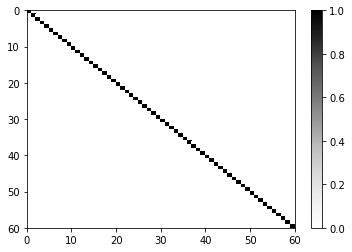

In [113]:
plt.pcolor(sigma, cmap = 'Greys')
plt.gca().invert_yaxis()
plt.colorbar()

In [114]:
r2_actual = r2_score(y_test, np.dot(X_test, beta))
print(r2_actual)

0.8752748206988183


### First, let's fit this data using ElasticNet with normalize = False

In [119]:
en = ElasticNetCV(normalize=False)
en.fit(X, y.ravel())
# Calculate the r2 score:
r2_model = r2_score(y_test, np.dot(X_test, en.coef_))
print(r2_model)

0.8573268207794946


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


### Now using normalize = True

In [120]:
en2 = ElasticNetCV(normalize = True, copy_X = True)
en2.fit(X, y.ravel())
r2_model = r2_score(y_test, np.dot(X_test, en2.coef_))
print(r2_model)

0.8330733187946714


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


### In the case when normalize is set to True, the selection profile of the algorithm is extremely restrictive, to the point of in this case setting all the coefficients to 0

Text(0.5, 1.0, 'Estimated coefficients with normalize=True')

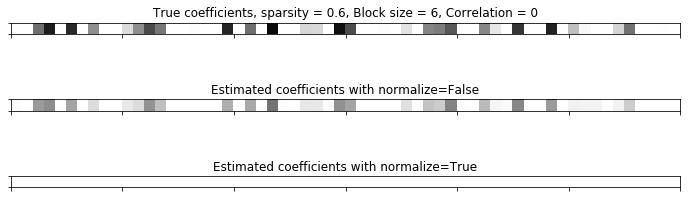

In [98]:
fig, ax = plt.subplots(3, 1, figsize=(12, 4))
# True beta
ax[0].set_aspect('equal')
ax[0].pcolor(beta.T, cmap='Greys', vmin = 0, vmax = 10)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_title('True coefficients, sparsity = 0.6, Block size = 6, Correlation = 0')

ax[1].set_aspect('equal')
ax[1].pcolor(en.coef_[:, np.newaxis].T, cmap='Greys', vmin = 0, vmax = 10)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title('Estimated coefficients with normalize=False')

ax[2].set_aspect('equal')
ax[2].pcolor(en2.coef_[:, np.newaxis].T, cmap='Greys', vmin = 0, vmax = 10)
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_title('Estimated coefficients with normalize=True')

### This effect varies as one varies the sparsity, and correlation magnitude, and block size, though in all cases the performance of the fit is extremely poor:

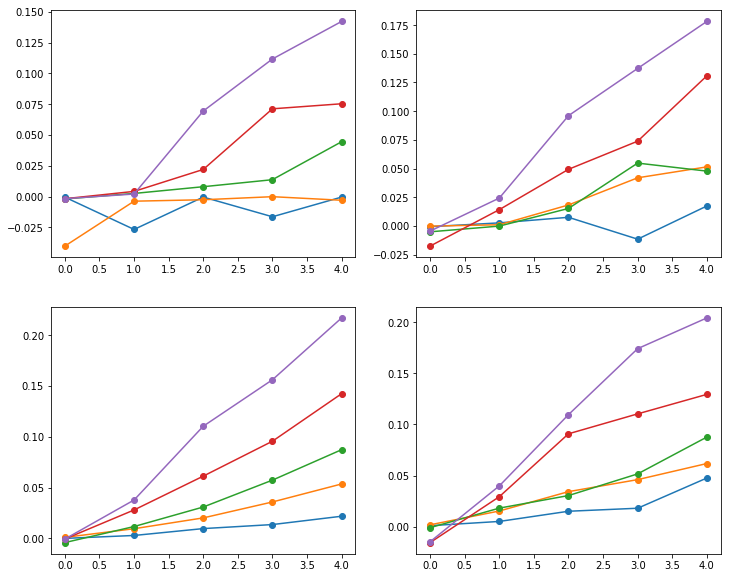

In [109]:
correlations = [0, 0.2, 0.4, 0.6, 0.8]
sparsity = [0.25, 0.5, 0.75, 1]
block_sizes = [6, 10, 12, 20, 30]
fig, ax = plt.subplots(2, 2, figsize = (12, 10))

for sidx, s in enumerate(sparsity):
    rscores = np.zeros((len(correlations), len(block_sizes)))
    a = ax[np.unravel_index(sidx, (2, 2))]
    for bidx, b in enumerate(block_sizes):
        for cidx, c in enumerate(correlations):
            X, X_test, y, y_test, beta, sigma = gen_data(correlation = c, sparsity = s, block_size = b)
            en = ElasticNet(normalize = True)
            en.fit(X, y.ravel())
            rscores[cidx, bidx] = r2_score(y_test, np.dot(X_test, en.coef_))
        
        a.plot(rscores[:, bidx], '-o')

### The effect is similar when using Lasso: